PANCREATIC TUMOR DETECTION

In [2]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from sklearn.model_selection import train_test_split
from monai.config import print_config
from monai.data import DataLoader, Dataset, ArrayDataset, CacheDataset
from monai.data.utils import pad_list_data_collate, decollate_batch
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet, UNet
from monai.losses import DiceCELoss
from monai.networks.layers import Norm
from monai.transforms import (
    Activations, AsDiscrete, Compose, LoadImaged, EnsureChannelFirstd, 
    EnsureTyped,Transform, AsDiscreted, CropForegroundd, 
    RandScaleIntensityd, RandShiftIntensityd, 
    NormalizeIntensityd, ResizeD, RandAffined, RandFlip,
    ToTensord, AddChanneld, ScaleIntensityRanged, 
    Orientationd, Spacingd, ToDeviced, RandGaussianNoised
)
import glob
from torchvision import transforms
from monai.utils import set_determinism

In [3]:
device = torch.device('cuda:2') 

In [4]:
# Set the data directory path
data_dir = "/home/Task07_Pancreas/"

# Get the file paths of the training images and labels
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

# Create a list of dictionaries, each containing an image-label pair
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

# Split the data into validation and training sets
val_files, train_files = data_dicts[:25], data_dicts[25:]

In [5]:
class GettheDesiredLabels(Transform):
    def __call__(self, data):
        # Extract the label from the input data
        label = data["label"]

        # Keep only the second and third channels from the label
        single_label = label[1:3]

        # Replace the original label with the modified label
        data["label"] = single_label

        # Return the modified data
        return data

In [6]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load the image and label data from file
    EnsureChannelFirstd(keys=["image", "label"]),  # Ensure the channel dimension is the first dimension
    ToDeviced(keys=["image", "label"], device="cuda:2"),  # Move the data to the specified device (commented out)
    # AsDiscreted(keys='label', to_onehot=3),  # Convert the label to one-hot encoding with 3 channels
    # GettheDesiredLabels(),  # Extract the desired channels from the label
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),  # Rescale the intensity values of the image within the specified range
    CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop the image and label to remove the background
    Orientationd(keys=["image", "label"], axcodes="RAS"),  # Adjust the image and label orientation to RAS
    Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),  # Adjust the spacing of the image and label
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize the image and label to the specified spatial size
    NormalizeIntensityd(keys=["image"]),  # Normalize intensity values of the image
    RandScaleIntensityd(keys=["image"], factors=0.1),  # Apply random scaling of intensity values to the image
    RandShiftIntensityd(keys=["image"], offsets=0.1),  # Apply random shifting of intensity values to the image
    RandGaussianNoised(keys=["image"], std=0.1),  # Add random Gaussian noise to the image
    ToTensord(keys=["image", "label"]),  # Convert the image and label to PyTorch tensors
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load the image and label data from file
    EnsureChannelFirstd(keys=["image", "label"]),  # Ensure the channel dimension is the first dimension
    # AsDiscreted(keys='label', to_onehot=3),  # Convert the label to one-hot encoding with 3 channels
    # GettheDesiredLabels(),  # Extract the desired channels from the label
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57,
        a_max=164,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),  # Rescale the intensity values of the image within the specified range
    CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop the image and label to remove the background
    Orientationd(keys=["image", "label"], axcodes="RAS"),  # Adjust the image and label orientation to RAS
    Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),  # Adjust the spacing of the image and label
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize the image and label to the specified spatial size
    ToTensord(keys=["image", "label"]),  # Convert the image and label to PyTorch tensors
])


In [7]:
train_dataset = CacheDataset(data=train_files, transform=train_transforms)  # Create a dataset for training with the training files and specified transformations
val_dataset = CacheDataset(data=val_files, transform=val_transforms)  # Create a dataset for validation with the validation files and specified transformations

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=pad_list_data_collate)  # Create a data loader for training with the training dataset
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=pad_list_data_collate)  # Create a data loader for validation with the validation dataset


Loading dataset: 100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


In [8]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 256
Number of validation samples: 25


In [9]:
sample_index = 0  # Specify the index of the sample to check
sample = train_dataset[sample_index]  # Retrieve the sample at the specified index from the training dataset
binarized_label = sample['label']  # Access the binarized label data from the sample
unique_values = torch.unique(binarized_label)  # Find the unique values in the binarized label
count = len(unique_values)  # Count the number of unique values
print(f"Number of unique values: {count}")  # Print the count of unique values


Number of unique values: 3


In [10]:
# Get the first sample in the dataset
first_sample = train_dataset[0]


image_shape = first_sample['image'].shape
label_shape = first_sample['label'].shape

print(f"Image shape: {image_shape}")
print(f"Label shape: {label_shape}")

Image shape: torch.Size([1, 224, 224, 144])
Label shape: torch.Size([1, 224, 224, 144])


In [28]:
# Create a colormap for the blue label
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

# Create a colormap for the red label
colors = [(1, 0, 0, i) for i in np.linspace(0, 1, 100)]
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_alpha', colors)

# Loop over samples in the dataset
for i in range(1, 3):
    val_data_example = train_dataset[i]

    # Select a slice to visualize (e.g., the middle slice)
    slice_idx = val_data_example['image'].shape[3] // 2  # Adjust to the depth dimension
    print(slice_idx)

    # Get image and labels
    image = val_data_example['image'][0, :, :, slice_idx].detach().cpu()
    label3 = val_data_example['label'][1, :, :, slice_idx].detach().cpu()
    label2 = val_data_example['label'][0, :, :, slice_idx].detach().cpu()

    # Create a figure
    plt.figure(figsize=(18, 6))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')

    # Overlay the labels on the image
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    plt.imshow(image, cmap='gray')
    plt.imshow(label2, cmap=blue_cmap, alpha=0.5)  # Use alpha for transparency
    plt.imshow(label3, cmap=red_cmap, alpha=0.5)

    # Show the plot
    plt.show()


72


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [12]:

model = SegResNet(
    blocks_down=[1, 2, 2, 4],  # Number of residual blocks in each downsampling path
    blocks_up=[1, 1, 1],  # Number of residual blocks in each upsampling path
    init_filters=16,  # Number of filters in the first layer
    in_channels=1,  # Number of input channels
    out_channels=3,  # Number of output channels
    dropout_prob=0.2,  # Dropout probability
).to(device)
loss_function = DiceLoss(include_background=False, squared_pred=True, to_onehot_y=True, sigmoid=True,
            smooth_nr=0, smooth_dr=1e-5)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")


In [13]:
max_epochs = 50
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=3)])
post_label = Compose([AsDiscrete(to_onehot=3)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 128)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
               
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50
1/256, train_loss: 0.9885
2/256, train_loss: 0.9970
3/256, train_loss: 0.9936
4/256, train_loss: 0.9841
5/256, train_loss: 0.9919
6/256, train_loss: 0.9933
7/256, train_loss: 0.9952
8/256, train_loss: 0.9849
9/256, train_loss: 0.9875
10/256, train_loss: 0.9931
11/256, train_loss: 0.9889
12/256, train_loss: 0.9891
13/256, train_loss: 0.9887
14/256, train_loss: 0.9912
15/256, train_loss: 0.9804
16/256, train_loss: 0.9770
17/256, train_loss: 0.9841
18/256, train_loss: 0.9826
19/256, train_loss: 0.9889
20/256, train_loss: 0.9911
21/256, train_loss: 0.9770
22/256, train_loss: 0.9729
23/256, train_loss: 0.9538
24/256, train_loss: 0.9882
25/256, train_loss: 0.9674
26/256, train_loss: 0.9822
27/256, train_loss: 0.9746
28/256, train_loss: 0.9922
29/256, train_loss: 0.9819
30/256, train_loss: 0.9557
31/256, train_loss: 0.9771
32/256, train_loss: 0.9809
33/256, train_loss: 0.9935
34/256, train_loss: 0.9700
35/256, train_loss: 0.9798
36/256, train_loss: 0.9883
37/256, train_l

KeyboardInterrupt: 

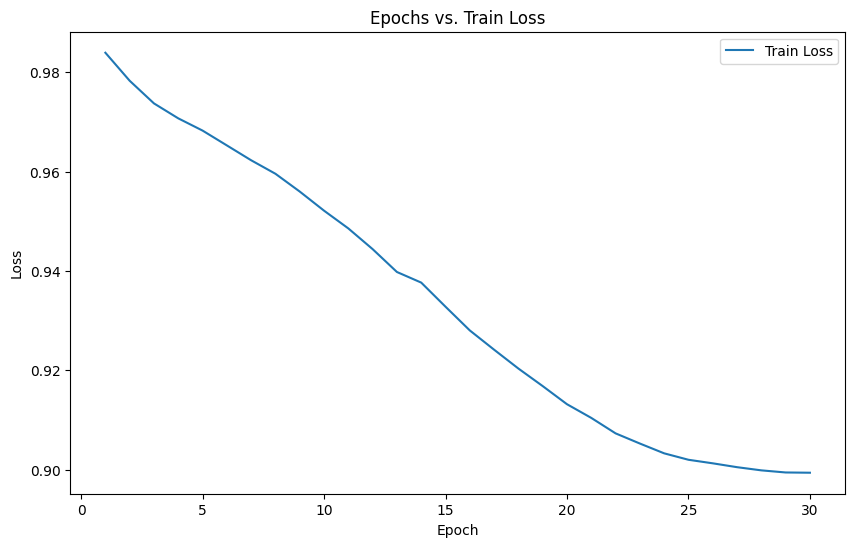

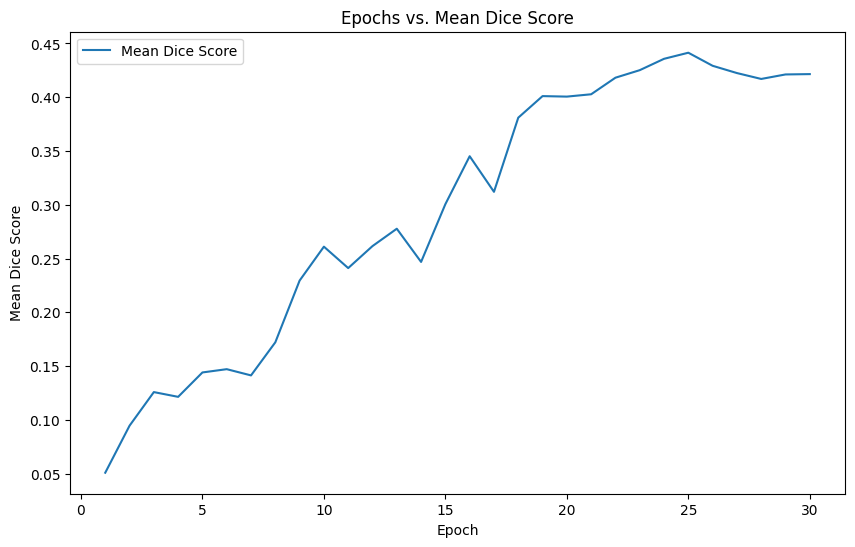

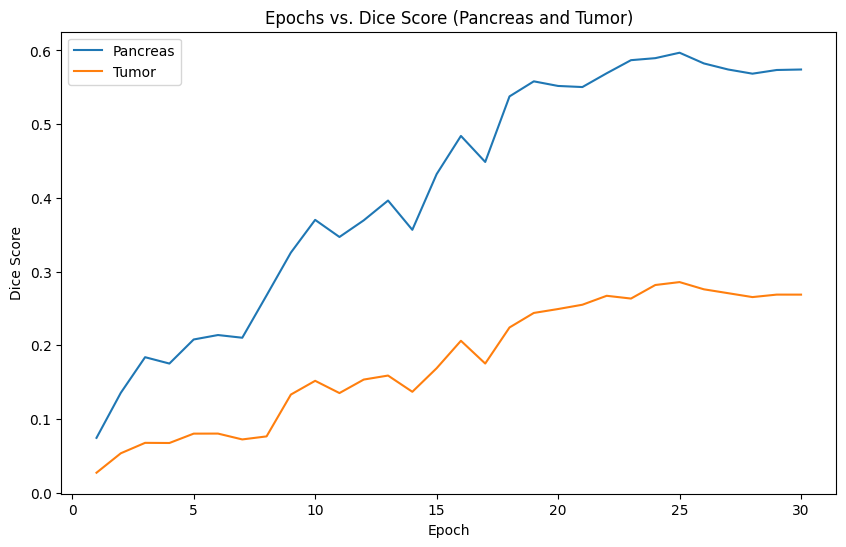

In [49]:
import matplotlib.pyplot as plt

# Plot epochs vs train loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_epochs + 1), epoch_loss_values, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs. Train Loss')
plt.legend()
plt.show()

# Plot epochs vs mean dice score
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values, label='Mean Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Mean Dice Score')
plt.title('Epochs vs. Mean Dice Score')
plt.legend()
plt.show()

# Plot epochs vs class 1, 2, and 3 dice scores
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class1, label='Pancreas')
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class2, label='Tumor')

plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Epochs vs. Dice Score (Pancreas and Tumor)')
plt.legend()
plt.show()


In [9]:
model_dir = "/home/model_codes/"
model=(torch.load(
    os.path.join(model_dir, "best_metric_model_bg_v4_mon1.pth")))

RuntimeError: applying transform <monai.transforms.post.array.AsDiscrete object at 0x7f758c062fa0>

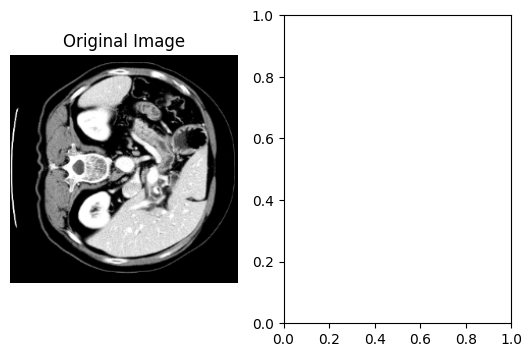

In [43]:
# Set the model to evaluation mode
model.eval()

# Create empty lists to store the original image, model prediction, and actual labels
original_images = []
model_predictions = []
actual_labels = []

# Iterate over the validation dataset
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        
        # Forward pass through the model to obtain the predictions
        val_outputs = model(val_inputs)
        
        # Convert the predicted outputs and actual labels to numpy arrays
        val_outputs = val_outputs.cpu().numpy()
        val_labels = val_labels.cpu().numpy()
        
        # Append the original image, model prediction, and actual labels to the respective lists
        original_images.append(val_inputs.cpu().numpy())
        model_predictions.append(val_outputs)
        actual_labels.append(val_labels)

# Convert the lists to numpy arrays
original_images = np.concatenate(original_images, axis=0)
model_predictions = np.concatenate(model_predictions, axis=0)
actual_labels = np.concatenate(actual_labels, axis=0)

from monai.transforms import AsDiscrete, Compose

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Iterate over the images in the validation set and visualize the original image, model prediction, and actual labels
for i in range(len(original_images)):
    plt.figure(figsize=(10, 4))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_images[i, 0, :, :, 72], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Plot the model prediction for the first output label
    plt.subplot(1, 3, 2)
    prediction = model_predictions[i, 0, :, :, 72]
    discrete_prediction = post_pred(prediction)
    plt.imshow(discrete_prediction[0], cmap='gray')
    plt.title("Model Prediction (Label 1)")
    plt.axis('off')
    
    # Plot the actual labels for the first output label
    plt.subplot(1, 3, 3)
    labels = actual_labels[i, 0, :, :, 72]
    discrete_labels = post_label(labels)
    plt.imshow(discrete_labels[0], cmap='gray')
    plt.title("Actual Labels (Label 1)")
    plt.axis('off')
    
    plt.show()


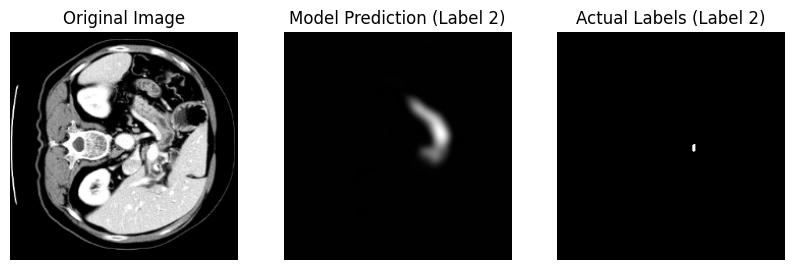

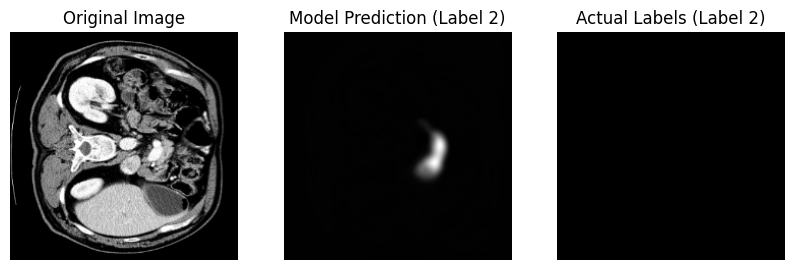

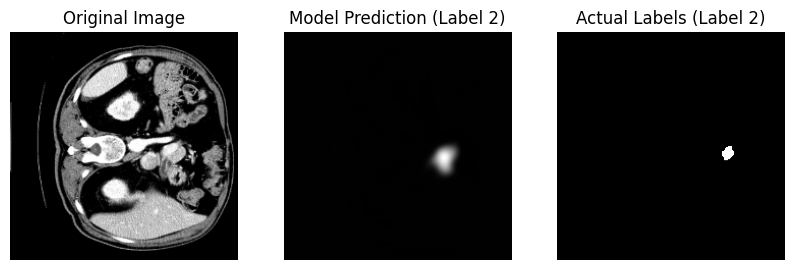

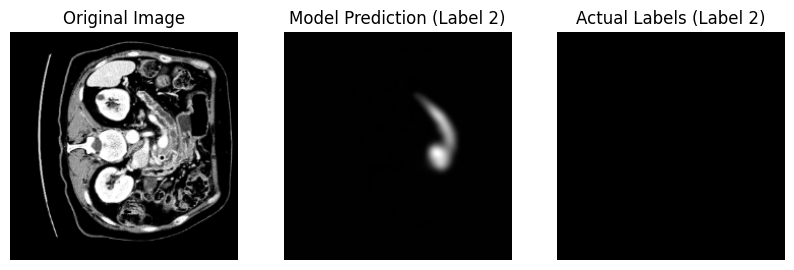

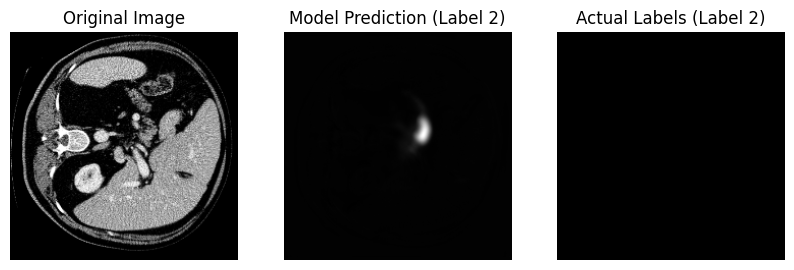

: 

In [51]:
# Set the model to evaluation mode
model.eval()

# Create empty lists to store the original image, model prediction, and actual labels
original_images = []
model_predictions = []
actual_labels = []

# Iterate over the validation dataset
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        
        # Forward pass through the model to obtain the predictions
        val_outputs = model(val_inputs)
        
        # Convert the predicted outputs and actual labels to numpy arrays
        val_outputs = val_outputs.cpu().numpy()
        val_labels = val_labels.cpu().numpy()
        
        # Append the original image, model prediction, and actual labels to the respective lists
        original_images.append(val_inputs.cpu().numpy())
        model_predictions.append(val_outputs)
        actual_labels.append(val_labels)

# Convert the lists to numpy arrays
original_images = np.concatenate(original_images, axis=0)
model_predictions = np.concatenate(model_predictions, axis=0)
actual_labels = np.concatenate(actual_labels, axis=0)

# Iterate over the images in the validation set and visualize the original image, model prediction, and actual labels
for i in range(len(original_images)):
    plt.figure(figsize=(10, 4))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_images[i, 0, :, :, 72], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Plot the model prediction for the second output label
    plt.subplot(1, 3, 2)
    plt.imshow(model_predictions[i, 1, :, :, 72], cmap='gray')
    plt.title("Model Prediction (Label 2)")
    plt.axis('off')
    
    # Plot the actual labels for the second output label
    plt.subplot(1, 3, 3)
    plt.imshow(actual_labels[i, 1, :, :, 72], cmap='gray')
    plt.title("Actual Labels (Label 2)")
    plt.axis('off')
    
    plt.show()